## This notebook shortly explains how to use Quandary through the python interface.
Latest update: 11/14/2023, Stefanie Guenther (guenther5@llnl.gov)

Content:
 1. How to generate control pulses for a **unitary gate**
 2. How to evaluate pulses on a specific sample rate
 3. How to get the propagator and/or the fidelity for given control parameters from Quandary?
 4. How to compare results to **QuTIP**?
 5. How to to generate pulses that realise a **state to state** transfer
 6. How to use the open-system solver to model decay and dephasing
 7. *Coming soon*: FAQ ("What if...")

The full Quandary user-guide can be found here:
https://github.com/LLNL/quandary/blob/pythoninterface/doc/user_guide/main.pdf \
The pythoninterface functions as used here are defined in './quandary.py'. That file might be a valuable resource to check for default settings and available options that are not described in this notebook. 

In [1]:
# Load Quandary python interface functions

# This requires to have the location of quandary.py in your PYTHONPATH. E.g., in the shell, type
#   > export PYTHONPATH=/path/to/quandary/:$PYTHONPATH
# Further, to run quandary, make sure that your quandary executable is in your $PATH variable. E.g. with
#   > export PATH=/path/to/quandary/:$PATH
from quandary import *
%matplotlib inline

### 1. How to use Quandary to generate pulses that realize a **unitary gate**

Executing ' mpirun -np  3 quandary ./config.cfg --quiet . Runtype:  optimization ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy 
0  9.01515106797588e-01 + 7.56688450300555e-07 + 1.70771506137339e-05 + 2.65273939142498e-07 + 1.16596605571299e-05  Fidelity = 9.84848932024121e-02  ||Grad|| = 2.36672188701292e-01
1  7.08824168583751e-01 + 1.08404852794896e-06 + 2.21561270073683e-05 + 2.50365182948080e-06 + 3.15623992210024e-05  Fidelity = 2.91175831416249e-01  ||Grad|| = 5.26715292435151e-01
2  9.49493141894147e-02 + 6.63286504808368e-07 + 1.60111032565354e-05 + 1.38032853363013e-06 + 1.87442082712003e-05  Fidelity = 9.05050685810585e-01  ||Grad|| = 3.75297345696423e-01
3  3.12404587975532e-02 + 6.04409646723860e-07 + 1.40206540893403e-05 + 1.47003934763770e-06 + 1.69019066433091e-05  Fidelity = 9.68759541202447e-01  ||Grad|| = 1.54539816357217e-01
4  2.83151317394603e-03 + 6.65027445079292e-07 + 1.39467689374924e-05 

/Users/guenther5/Numerics/quandary/quandary.py:1157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.waitforbuttonpress(1);


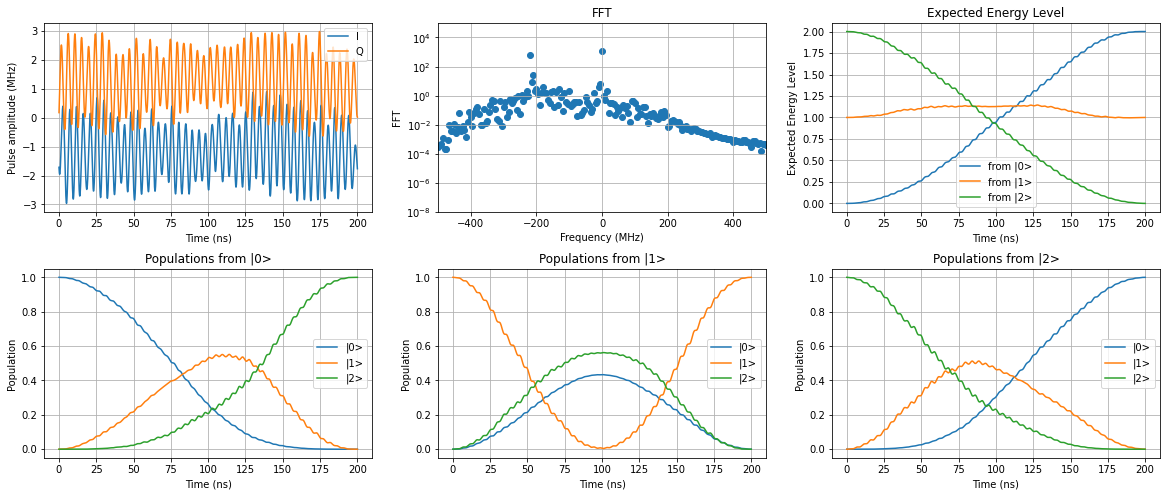

In [2]:
#
# THE SHORT STORY...
# 
# Example usage of Quandary to optimize for a SWAP 02 gate. 
# This example considers a three-level qubit with one extra guard level.

# Define the number of qubits and states per qubit. Here: One qudit modelled with 3 essential levels and one extra guard level
Ne = [3]   # essential levels per qubit
Ng = [1]   # guard levels per qubit

# Required: Define the target gate and pulse duration
unitary = [[0,0,1],[0,1,0],[1,0,0]]   # Target unitary gate, here SWAP02
pulse_length = 200.0                  # Pulse duration, unit ns

# Optionally: Set bounds on the control pulse amplitudes in rotational frame [MHz]
maxctrl_MHz = 4.0  

# Pass all options to the Quandary constructor. Check out other default options within the Quandary class, e.g. with help(Quandary)
quandary = Quandary(Ne=Ne, Ng=Ng, targetgate=unitary, T=pulse_length, maxctrl_MHz=maxctrl_MHz, rand_seed=1234)

# Optimize with quandary. Check help(quandary.optimize). This runs in the background on <prod(Ne)> cores. 
t, p, q, infidelity, expectedEnergy, population = quandary.optimize()
print(f"\nOptimized Fidelity = {1.0 - infidelity}")

# Quandary returns:
#   - t              : a list of time-points where the optimized control pulses are stored (ns) 
#   - p, q           : lists of the control pulses p(t) and q(t) for each qubit (list(list)), unit MHz, evaluated at each time point in the list t
#   - infidelity     : 1-fidelity of the realized unitary compared to the target gate
#   - expectedEnergy : lists of the extected energy level of each qubit evaluated at each time point 
#   - population     : lists of the level occupations (population) evaluated at each time point, one list for each initial basis state 

# In addition, the following other results can be accessed after quandary.optimize() has been called:
#   - quandary.popt  (list)   : The optimized B-spline parameters that define the optimized pulses p and q
#   - quandary.uT    (matrix) : The final state at time T of each of the initial states. For gate optimization (basis initial states), this is the solution operator / process matrix / propagator, see below

# Plot the results. Other plotting functions are available, see quandary.py
plot_results_1osc(quandary, p[0], q[0], expectedEnergy[0], population[0])

In [3]:
#
# THE LONG STORY...
#
# Quandary uses B-spline basis functions to parameterize control pulses p and q. It then solves Schroedinger's equation (or alternatively Lindblad's master equation, see 6.) for each initial state to compute the solution operator and compares it to the target unitary gate. Quandary then applies a gradient-based optimization method to optimize the B-spline coefficients that yield optimized pulses. 
# Check out help(Quandary) and help(quandary.optimize) to see all options you can set, and their default values.

# Useful optional arguments for Quandary(...) that determine how quandary.optimize operates. Here are some selected ones. See help(Quandary) for a list of all options.
#   * pcof0               (List)  : Initial guess for the optimization variables in terms of the Bspline coefficients. 
#   * pcof0_filename      (String): Load the initial guess for the Bspline coefficients from this file (Format: Text file containing the list of coefficients in one column. 
#   * initctrl_MHz        (Float) : Amplitude of the initial pulse guess (if randomized, the initial pulse amplitude will be smaller than this number). Default: 1 MHz
#   * randomize_init_ctrl (Bool)  : Switch whether initial control pulse should be a randomized pulse, or a constant pulse. Default: True (randomized). Only active if pcof0 is NOT given.
#   * rand_seed           (int)   : Fixed seed for the random number generator (Default: system time, non reproducable)
#   * control_enforce_BC  (Bool)  : Switch whether the control pulses should start and end at zero (p(t)=0 at t=0 and t=T). Default 'False'. 
#   * nsplines            (Int)   : Number of Bspline basis functions used to parameterize the pulse. Default = T/10.0 + 2, gives a 10ns spacing between the bspline basis functions. 
#   * tol_infidelity      (Float) : Targeted accuraty of the pulses in terms of the fidelity. Default '1e-4' gives a 99.99% fidelity gate). 
#   * maxiter             (Int)   : Maximum number of optimization iterations (default 100).
#   * Pmin                (Int)   : Use this many time-points to discretize one period of the solution. The higher the number, the more accurate the solution will be, and the longer the computation will take. (Default: 150)
#   * verbose             (Bool)  : Flag to print more output (default: false). Usefull for debugging.


# Optional arguments for quandary.optimize(...):
#   * pcof0       (List)    : Use this as an initial guess for the Bspline coefficients. Overwrites the field in quandary.pcof0
#   * datadir     (String)  : Output directory where Quandary is executed
#   * ncores.     (Int)     : Number of compute cores (default: <number of essential levels>, here 3 by default)


In [4]:
# The quandary.simulate() function has a similar interface and can be used to *simulate* the dynamics, given Bspline control coefficients that define the pulses:
opt_bspline_params = quandary.popt[:]      # Here, I'm using the previously optimized control parameters.
t, p, q, infidelity, _, _ = quandary.simulate(pcof0=opt_bspline_params)

Executing ' mpirun -np  3 quandary ./config.cfg --quiet . Runtype:  simulation ...
Objective = 9.91305462126890e-05 + 6.68775328620277e-07 + 8.71996182732833e-06 + 1.71052471222484e-06 + 1.92443923560427e-05
Fidelity = 9.99900869453787e-01


### 2. How to evaluate control pulses on a specific sample rate

Executing ' quandary ./config.cfg --quiet . Runtype:  evalcontrols ...

Plotting control pulses.
-> Press <enter> to proceed.


/Users/guenther5/Numerics/quandary/quandary.py:1012: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.waitforbuttonpress(1);


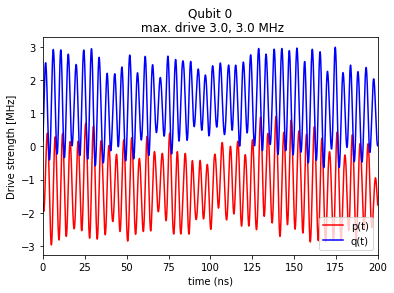

In [5]:
# Quandary.optimize(..) returns control pulses p and q (unit MHz) that are evaluated at each time point in t 
# In oder to evaluate p and q on a different time grid (i.e. to downsample or upsample the pulse), use the following:
samplerate = 64
t_ds, p_ds, q_ds = quandary.evalControls(pcof0=quandary.popt, points_per_ns=samplerate)

plot_pulse(quandary.Ne, t_ds, p_ds, q_ds)

# Note, p and q are lists of lists (one list for each qubit), hence accessing the first qubit's control is in p[0], e.g.
# plt.plot(t_ds, p_ds[0])  
# plt.plot(t_ds, q_ds[0])

### 3. How to get the propagator and/or fidelity for given control parameters from Quandary

In [6]:
# After a quandary.optimize/simulate(), the field quandary.uT contains the propagated states at the final time, for each of the initial states. 
# If the initial states are the full basis (default), then this is the solution operator / process matrix / propagator
# Here an example, simulating with previously optimized and slighly perturbed Bspline control parameters 
coeffs_perturb = np.zeros(len(quandary.popt))
for i in range(len(coeffs_perturb)):
    coeffs_perturb[i] = quandary.popt[i] + 0.001

t, p, q, infidelity, _, _ = quandary.simulate(pcof0=coeffs_perturb) 
propagator_T = quandary.uT   

# In the example here, uT is a 4x3 matrix (!) because here Quandary was configured with Ne=[3] energy states and Ng=[1] guard level. Hence uT is a 4x3 matrix whose columns are for each of the 3 initial basis states and rows are the 3+1 energy levels). 
# Hopefully, the guard levels are not populated such that you can ignore the last row to extract the 3x3 propagator:
propagator_3x3 = propagator_T[:-1,:] 

print("Propagator = ", propagator_3x3)
print(f"Pulse Fidelity = {1.0 - infidelity}")

# You can also compute the fidelity from the propagator and unitary gate directly, e.g. with
fid = np.abs(np.trace(propagator_3x3.conj().T @ unitary))**2/np.prod(quandary.Ne)**2     # ('@' for numpy matrix mult)
print('Test Pulse Fidelity = ', fid)   

Executing ' mpirun -np  3 quandary ./config.cfg --quiet . Runtype:  simulation ...
Objective = 7.88478427193311e-02 + 6.06093011629377e-07 + 7.01401375410766e-06 + 1.77996722552265e-06 + 1.74331975865308e-05
Fidelity = 9.21152157280669e-01
Propagator =  [[-0.17599657+0.01194077j  0.16676533+0.1019571j  -0.93535995+0.23613982j]
 [-0.15730409+0.12076079j -0.96501199+0.0623861j  -0.10338956+0.12167315j]
 [-0.96410644-0.00675028j  0.13544784+0.09094835j  0.20602539-0.03698267j]]
Pulse Fidelity = 0.921152157280669
Test Pulse Fidelity =  0.9211521572810436


### 4. How to compare results to QuTIP?

In [7]:
# Here is an example for comparing Quandary's prediction to simulation with QuTIP.
from qutip import Qobj, propagator

# First, I'm using Quandary to simulate the dynamics driven by the above perturbed Bspline coefficients, while modelling the first 3 energy levels
quandary = Quandary(Ne=[3], Ng=[0], targetgate=unitary, T=pulse_length)
t, p, q, infidelity, _, _ = quandary.simulate(pcof0=coeffs_perturb) 
# Now, I'm extracting the propagator and compute the fidelity with respect to the unitary target defined above
propagator_quandary = quandary.uT
fidelity_quandary = np.abs(np.trace(propagator_quandary.conj().T @ unitary))**2/np.prod(quandary.Ne)**2 
print("Quandary fidelity: ", fidelity_quandary)

# QuTip requires pulses to be defined in rad/ns, so here I convert the output from quandary from MHz to rad / ns
p_radns = np.array(p[0])*1e-3*(2*np.pi)
q_radns = np.array(q[0])*1e-3*(2*np.pi)

# For some reason, QuTIP can not handle the time variable t from Quandary, so we set up a new one here...
samplerate = quandary.nsteps / quandary.T     # Sample rate of controls from Quandary
t_new = np.arange(0, len(p[0]))*1/samplerate

# Define the Hamiltonian model for QuTIP. Here, I'm taking the Hamiltonians as used in Quandary
h0 = quandary.Hsys              # System Hamiltonian
hc_re = quandary.Hc_re[0]       # Control Hamiltonian for first qubit, real part
hc_im = 1.0j*quandary.Hc_im[0]  # Control Hamiltonian for first qubit, imaginary part

# Solve Hamiltonian dynamics with Qutip
H = [Qobj(h0), [Qobj(hc_re), p_radns], [Qobj(hc_im), q_radns]]
U_all = propagator(H, t_new)

# Grab last time-step (propagator)
nstates = np.prod(quandary.Ne)
propagator_qutip = Qobj(U_all[-1][:nstates,:nstates])

# Compute the fidelity with the target unitary 
fidelity_qutip = np.abs(np.trace(propagator_qutip.dag() * Qobj(unitary)))**2/nstates**2
print('QuTIP fidelity: ', fidelity_qutip)

# Check: Both fidelities should be fairly close to each other.

Executing ' mpirun -np  3 quandary ./config.cfg --quiet . Runtype:  simulation ...
Objective = 7.89591322635279e-02 + 6.06093011629377e-07 + 0.00000000000000e+00 + 1.77635445639020e-06 + 1.74332248307182e-05
Fidelity = 9.21040867736472e-01
Quandary fidelity:  0.9210408677312315
QuTIP fidelity:  0.9210922905233985


### 5. How to use Quandary to generate pulses that realize a **state-to-state transfer**

Executing ' quandary ./config.cfg --quiet . Runtype:  optimization ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy 
0  4.92896546738189e-01 + 2.21008178502730e-10 + 0.00000000000000e+00 + 5.71613862622368e-15 + 8.27271005826681e-09  Fidelity = 5.07103453261811e-01  ||Grad|| = 1.70078108093121e+01
1  4.24919496932892e-02 + 1.70616509371277e-07 + 0.00000000000000e+00 + 1.50086380611334e-09 + 9.91369542882719e-06  Fidelity = 9.57508050306711e-01  ||Grad|| = 6.86209639801545e+00
2  5.73631878829173e-03 + 8.72278162710343e-08 + 0.00000000000000e+00 + 7.56210130921460e-10 + 5.06663232177590e-06  Fidelity = 9.94263681211708e-01  ||Grad|| = 2.56875562610845e+00
3  2.45814323485138e-06 + 1.07188551686189e-07 + 0.00000000000000e+00 + 9.74194815930997e-10 + 6.22689130835045e-06  Fidelity = 9.99997541856765e-01  ||Grad|| = 5.06614324661478e-02
Optimization converged with small infidelity.

Fidelity = 0.999997541856765

Plottin

/Users/guenther5/Numerics/quandary/quandary.py:1157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.waitforbuttonpress(1);


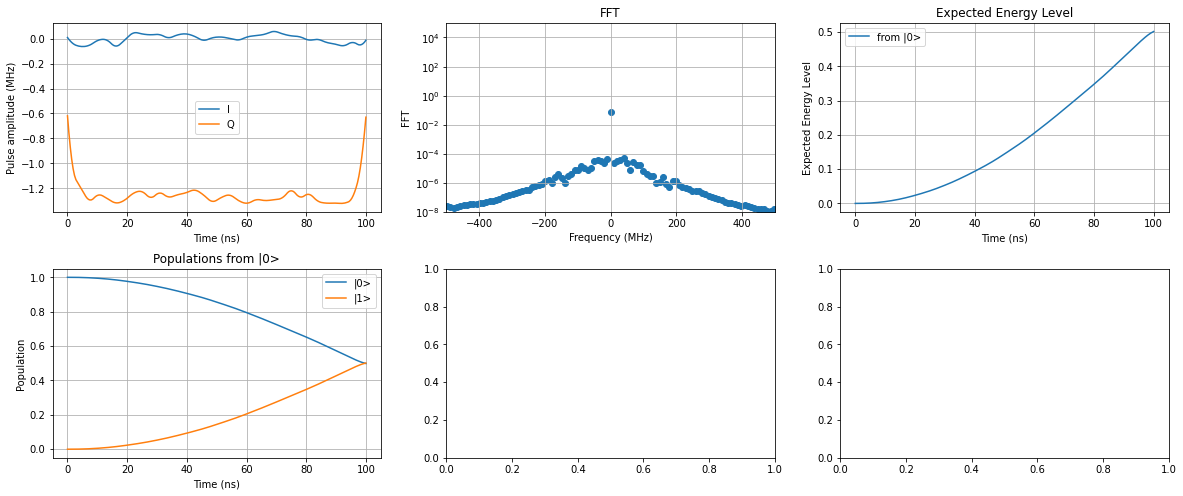

In [8]:
# 
# THE SHORT STORY
# 
# Example how to use Quandary to optimize a state-to-state transfer 

# Optionally: Define the number of essential state and guard levels. This example considers a 2-level qubit with no extra guard level. Default would be 3-level and no guard level, so we change it here
Ne = [2]    # Number of essential states per qubit 

# Define the target and the initial state (in the essential level dimensions)
initialcondition = [1.0, 0.0]
targetstate =  [1.0/np.sqrt(2), 1.0/np.sqrt(2)]   

# Pulse length
T = 100.0

# Optionally: Define desired accuraty of the pulse in terms of the infidelity. 
tol_infidelity = 1e-5

# Optionally: Set the initial control pulse amplitude. Default is 10MHz, leading to larger controls than neccessary here, so we decrease it here.
initctrl_MHz=0.1

# Pass all options to the Quandary configuration
quandary = Quandary(Ne=Ne, T=T, targetstate=targetstate, initialcondition=initialcondition, tol_infidelity=tol_infidelity, initctrl_MHz=initctrl_MHz, rand_seed=1234)

# Execute quandary. Runs in the background on one core. 
t, pt, qt, infidelity, expectedEnergy, population = quandary.optimize() 
print(f"\nFidelity = {1.0 - infidelity}")

# The realized state at the final time is in quandary.uT
realized_state= quandary.uT

# Plot the control pulse and expected energy level evolution.
plot_results_1osc(quandary, pt[0], qt[0], expectedEnergy[0], population[0])

In [9]:
#
# THE LONG STORY... compare above long story on gate optimization, here continued and adapted for state-to-state transfer
#

# In contrast to gate optimization, the state-to-state transfer only requires to propagate ONE initial state through the time domain, not the entire basis of initial states. The objective function compares the propagated initial state to the target, and performs an optimization on this measure.
# When setting up a state-to-state problem, the only difference to the gate optimization is therefore that, instead of a "targetgate", one passes the keyword "targetstate" (vector) to the configuration, alongside an "initialcondition" identifier for selecting an arbitrary initial state at t=0.
# All other configuration options as explained above are still available and have the same effect as they do for gate optimization. 

# Important note: After solving for a state-to-state problem (optimization or simulation), the variable quandary.uT consists only of ONE column, being the propagated initial state at final time t. 
# Hence, quandary.uT is NOT THE PROPAGATOR! (Since only one initial state has been propagated, the process matrix is not available yet)
# To compute the propagator /solution matrix / unitary that maps the initial to the target state, one needs to simulate the dynamics for all initial states, using the optimized pulses,  e.g. by doing so:
quandary.initialcondition = "basis"
quandary.update()   # call update() after you have changed quandary member variables directly as above
t, pt, qt, _, _, _ = quandary.simulate(pcof0=quandary.popt, datadir="./test")
# Note: The fidelity that is returned and printed out in this call, is MEANINGLESS. Ignore it. Instead, compute fidelity from the blow code.

# Now grab the propagator
uT = quandary.uT
# print("Propagator: ", uT)

# TEST the fidelity: Check whether uT indeed maps the initial [1,0] state to the desired target state:
test_fid = np.abs(np.array(targetstate).conj() @ uT @ initialcondition)   # Overlap between target state and evolved state
print("Test fidelity = ", test_fid)

Executing ' mpirun -np  2 quandary ./config.cfg --quiet . Runtype:  simulation ...
Objective = 7.50693232217165e-01 + 1.07188551686190e-07 + 0.00000000000000e+00 + 9.74194815931074e-10 + 6.22689130835046e-06
Fidelity = 2.49306767782835e-01
Test fidelity =  0.999998770928759


### 6. How to use the open-system solver to model decay and dephasing

Executing ' quandary ./config.cfg --quiet . Runtype:  optimization ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy 
0  4.95093877640180e-01 + 2.37157458641785e-10 + 0.00000000000000e+00 + 8.48886922237297e-15 + 6.18295381973677e-09  Fidelity = 5.04906122359820e-01  ||Grad|| = 1.06050793701288e-01
1  4.33637442278156e-02 + 1.71295862475575e-07 + 0.00000000000000e+00 + 1.18029933501381e-09 + 9.93549045871399e-06  Fidelity = 9.56636255772184e-01  ||Grad|| = 2.91008508681472e-01
2  5.89641442782529e-03 + 8.69492943530913e-08 + 0.00000000000000e+00 + 5.60516124641424e-10 + 5.03812649992486e-06  Fidelity = 9.94103585572175e-01  ||Grad|| = 7.20595410555997e-02
3  2.84392818250545e-06 + 1.07170517944485e-07 + 0.00000000000000e+00 + 7.32340225375347e-10 + 6.21216158866204e-06  Fidelity = 9.99997156071817e-01  ||Grad|| = 5.83831714479165e-02
Optimization converged with small infidelity.

Optimized Fidelity = 0.99999715607181


Re-optimized Fidelity under noise = 0.999900283804535

Plotting results...
-> Press <enter> to proceed.



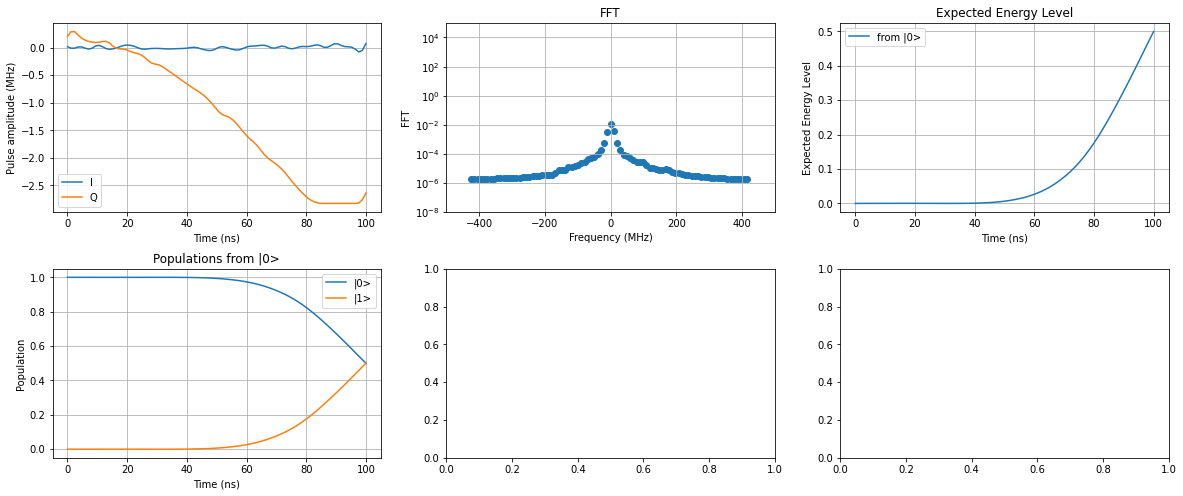

In [10]:
# You can simulate the dynamics under Lindbladian noise operators in Quandary (for decay and dephasing noise).
# To do so, the only thing to change is to pass the decay and dephasing times to the quandary configuration. All other options and runtypes are the same. 
# Note that the Lindblad solver is computationally more expensive, especially for gate optimization. It might be good to pre-optimize on the closed system first and use the optimized parameters as initial guess for the Lindblad solver.
# Here is an example for the state-to-state transfer problem

# State-to-state transfer configuration
Ne = [2]    # Number of essential states
targetstate  =  [1.0/np.sqrt(2), 1.0/np.sqrt(2)]   # target state
initialstate = [1.0, 0.0]      # initial ground state
T = 100.0                      # pulse length
tol_infidelity = 1e-5          # Infidelity tolerance
maxiter = 50                   # Maximum number of iterations

maxctrl_MHz = 4.0              # Maximum allowed control pulse amplitude [MHz]
initctrl_MHz = 0.1             # Initial guess for control pulse amplitude [MHz]

T1 = [100000.0]  # T1 decay time [ns]
T2 = [80000.0]   # T2 dephasing time [ns]
quandary_lblad = Quandary(Ne=Ne, T=T, T1=T1, T2=T2, targetstate=targetstate, initialcondition=initialstate, maxctrl_MHz=maxctrl_MHz, initctrl_MHz=initctrl_MHz, maxiter=maxiter)

# Create and pre-optimize on the closed-system solver:
quandary_closed = quandary_lblad.copy()
quandary_closed.T1=[]   # disable T1 and T2, don't forget to update() quandary
quandary_closed.T2=[]
quandary_closed.update()
t, pt, qt, infidelity, expectedEnergy, population = quandary_closed.optimize() 
print(f"\nOptimized Fidelity = {1.0 - infidelity}")

# Evaluate the optimized pulses using the open system solver:
t, pt, qt, infidelity, expectedEnergy, population = quandary_lblad.simulate(pcof0=quandary_closed.popt) 
print(f"\nFidelity under noise = {1.0 - infidelity}")

# Further optimize on the lindblad solver
t, pt, qt, infidelity, expectedEnergy, population = quandary_lblad.optimize(pcof0=quandary_closed.popt) 
print(f"\nRe-optimized Fidelity under noise = {1.0 - infidelity}")

# # Plot the control pulse and expected energy level evolution.
plot_results_1osc(quandary_lblad, pt[0], qt[0], expectedEnergy[0], population[0])

In [11]:
# ## COMING SOON: FAQ

# * What to do if the optimizer does not converge?
#     - Run again with a different initial guess (rand_seed=<different integer>, randomize_ctrl_init=True/False, initctrl_MHz=<double>)
#     - Remove or increase the control bounds (maxctrl_MHz=<larger double or list>)
#     - Increase the time domain (T)
#     - Increase the number of iterations (maxiter)
#     - Increase the number of Bspline basis functions (increase nsplines, or decrease dtau)
#     - Inspect the files written to './run_dir/' (or the user-defined alternative output directory). In particular config.cfg, targetgate/state.dat.

# * What to do if the results don't match to other software, or to my expectations?
#     - Turn on 'verbose=True' and check screen output of quandary.simulate(). Anything suspicious?
#     - Test if the time-step size is small enough (aka if "Pmin" is large enough):
#       Compare the outcome (uT or fidelity) of various simulation runs, for increasing numbers of time-steps (increasing "Pmin"). The fidelity amongst those runs should not vary much. If it does, the time-step size should be decreased (by using a larger "Pmin"). Have a look at the 'timestep_richardson_est' function in quandary.py, which might be helpful to do this test.  
#     - Check if the correct pulses are used (e.g. by plotting the returned p and q after "simulation" runs as well as after calling 'evalControl(..)')

# Any time: Please reach out to guenther5@llnl.gov if you have any questions, concerns, or if you found a bug.  